### Compare structural measures across datasets

#### Datasets
- NIMHANS
- QPN
- PPMI

#### Measures
- Cortical thickness (FS)
- Regional volumes (FS)

In [1]:
import pandas as pd
import numpy as np
import scipy.stats
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import nibabel as nib
from nilearn import datasets, surface, plotting


In [2]:
projects_dir = f"/home/nikhil/projects/Parkinsons//neuro_arch/analysis" 

nimhans_serb_agg_data_dir = f"{projects_dir}/derived_data/nimhans_serb/agg_dfs/"
nimhans_metal_agg_data_dir = f"{projects_dir}/derived_data/nimhans_metal/agg_dfs/"
qpn_agg_data_dir = f"{projects_dir}/derived_data/qpn/agg_dfs/"
ppmi_agg_data_dir = f"{projects_dir}/derived_data/ppmi/agg_dfs/"

CT_DKT_csv = "CT_DKT_df.csv"
bilateral_vol_csv = "bilateral_vol_ASEG_df.csv"
global_vol_csv = "global_vol_ASEG_df.csv"

# save dirs
figs_dir = "../figs/population_comparisons"

demo_cols = ["participant_id","bids_id","age","sex","group","hemi","dataset"]

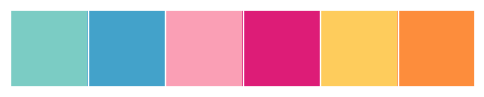

In [9]:
from enum import Enum
class my_colors(Enum):
    NIM_CONTROL = "#7bccc4"
    NIM_SERB_PD = "#43a2ca"
    NIM_METAL_PD = "#756bb1"
    QPN_CONTROL = "#fa9fb5"
    QPN_PD = "#dd1c77"
    PPMI_CONTROL = "#fecc5c"
    # PPMI_PRODROMAL = "#fecc5c"
    PPMI_PD = "#fd8d3c"
    
# color_list = [my_colors.NIM_CONTROL.value, my_colors.NIM_SERB_PD.value, my_colors.NIM_METAL_PD.value, 
#               my_colors.QPN_CONTROL.value, my_colors.QPN_PD.value, 
#               my_colors.PPMI_CONTROL.value, my_colors.PPMI_PRODROMAL.value, my_colors.PPMI_PD.value]

color_list = [my_colors.NIM_CONTROL.value, my_colors.NIM_SERB_PD.value,
              my_colors.QPN_CONTROL.value, my_colors.QPN_PD.value, 
              my_colors.PPMI_CONTROL.value, my_colors.PPMI_PD.value]

palette = sns.color_palette(palette=color_list) #sns.husl_palette()

hue_order = ["NIMHANS_SERB-control", "NIMHANS_SERB-PD", "NIMHANS_METAL-PD", "QPN-control", "QPN-PD",
              "PPMI-control",  "PPMI-PD"] #"PPMI-prodromal",

sns.palplot(palette)

### Read data

In [10]:
match_age = True
age_thresh = 63

In [11]:
# NIMHANS (SERB + METAL)
nimhans_serb_CT_DKT_df = pd.read_csv(f"{nimhans_serb_agg_data_dir}{CT_DKT_csv}").drop(columns=["Unnamed: 0"])
nimhans_serb_CT_DKT_df["dataset"] = "NIMHANS_SERB"
n_nimhans_serb_participants = len(nimhans_serb_CT_DKT_df["participant_id"].unique())

nimhans_metal_CT_DKT_df = pd.read_csv(f"{nimhans_metal_agg_data_dir}{CT_DKT_csv}").drop(columns=["Unnamed: 0"])
nimhans_metal_CT_DKT_df["dataset"] = "NIMHANS_METAL"
n_nimhans_metal_participants = len(nimhans_metal_CT_DKT_df["participant_id"].unique())

# QPN
qpn_CT_DKT_df = pd.read_csv(f"{qpn_agg_data_dir}{CT_DKT_csv}").drop(columns=["Unnamed: 0"])
qpn_CT_DKT_df["dataset"] = "QPN"
n_qpn_participants = len(qpn_CT_DKT_df["participant_id"].unique())

# PPMI
ppmi_CT_DKT_df = pd.read_csv(f"{ppmi_agg_data_dir}{CT_DKT_csv}").drop(columns=["Unnamed: 0"])
ppmi_CT_DKT_df["dataset"] = "PPMI"
ppmi_CT_DKT_df["participant_id"] = ppmi_CT_DKT_df["participant_id"].astype(str)
ppmi_CT_DKT_df["bids_id"] = "sub-" + ppmi_CT_DKT_df["participant_id"]

n_ppmi_participants = len(ppmi_CT_DKT_df["participant_id"].unique())

print(f"n_nimhans_participants: {(n_nimhans_serb_participants, n_nimhans_metal_participants)}, n_qpn_participants (all):{n_qpn_participants}, n_ppmi_participants: {n_ppmi_participants}")

if match_age:
    print(f"Matching age < {age_thresh}")
    qpn_CT_DKT_df = qpn_CT_DKT_df[qpn_CT_DKT_df["age"]<age_thresh]
    ppmi_CT_DKT_df = ppmi_CT_DKT_df[ppmi_CT_DKT_df["age"]<age_thresh]

    n_qpn_participants = len(qpn_CT_DKT_df["participant_id"].unique())
    n_ppmi_participants = len(ppmi_CT_DKT_df["participant_id"].unique())

    print(f"n_nimhans_participants: {(n_nimhans_serb_participants, n_nimhans_metal_participants)}, n_qpn_participants (young):{n_qpn_participants}, n_ppmi_participants: {n_ppmi_participants}")

# Concat
CT_DKT_df = pd.concat([nimhans_serb_CT_DKT_df, nimhans_metal_CT_DKT_df, qpn_CT_DKT_df,ppmi_CT_DKT_df], axis=0) #ppmi_CT_DKT_df
CT_DKT_df["ds_group"] = CT_DKT_df["dataset"] + "-" + CT_DKT_df["group"]
print(f"CT_DKT_df shape: {CT_DKT_df.shape}, n_total_participants: {len(CT_DKT_df['participant_id'].unique())}")


## tmp
# CT_DKT_df = CT_DKT_df.drop(columns=["participant_id"])

CT_DKT_df.head()

n_nimhans_participants: (86, 66), n_qpn_participants (all):201, n_ppmi_participants: 406
Matching age < 63
n_nimhans_participants: (86, 66), n_qpn_participants (young):81, n_ppmi_participants: 195
CT_DKT_df shape: (856, 39), n_total_participants: 428


,caudalanteriorcingulate,caudalmiddlefrontal,cuneus,entorhinal,fusiform,inferiorparietal,inferiortemporal,insula,isthmuscingulate,lateraloccipital,...,supramarginal,transversetemporal,participant_id,bids_id,age,sex,group,hemi,dataset,ds_group
0,2.643,2.648,1.866,3.932,3.098,2.638,2.969,3.294,2.312,2.189,...,2.717,2.386,SERB088,sub-SERB088,54.0,M,PD,lh,NIMHANS_SERB,NIMHANS_SERB-PD
1,3.230,2.844,1.941,3.825,2.900,2.479,3.003,3.427,2.308,2.365,...,2.589,1.971,SERB058,sub-SERB058,64.0,M,PD,lh,NIMHANS_SERB,NIMHANS_SERB-PD
2,2.756,2.717,1.997,3.036,2.709,2.457,2.875,3.183,2.388,2.123,...,2.526,1.875,SERB049,sub-SERB049,62.0,M,PD,lh,NIMHANS_SERB,NIMHANS_SERB-PD
3,2.974,2.603,1.819,3.802,2.701,2.399,2.947,3.205,2.468,2.364,...,2.532,2.250,SERB084,sub-SERB084,NaN,NaN,PD,lh,NIMHANS_SERB,NIMHANS_SERB-PD
4,3.015,2.939,1.998,4.177,3.054,2.831,3.403,3.701,2.462,2.382,...,2.933,2.776,SERB063,sub-SERB063,56.0,M,PD,lh,NIMHANS_SERB,NIMHANS_SERB-PD


### Subsample QPN to match age

In [12]:
CT_DKT_df.groupby(["dataset","group"])["age"].describe()

count       mean        std   min    25%   50%  \
dataset       group                                                       
NIMHANS_METAL PD         118.0  53.644068  10.089790  24.0  46.00  55.0   
NIMHANS_SERB  PD         108.0  55.388889   7.165381  36.0  50.00  56.0   
              control     30.0  52.000000   5.907330  41.0  48.50  53.0   
PPMI          PD         210.0  54.247619   5.691900  38.0  50.00  55.0   
              control     84.0  51.642857   7.890276  31.0  46.00  53.5   
              prodromal   96.0  56.187500   4.427932  42.0  53.75  57.0   
QPN           PD         136.0  55.961765   5.279760  40.9  53.20  57.1   
              control     26.0  52.515385   7.628247  37.7  49.80  55.4   

                           75%   max  
dataset       group                   
NIMHANS_METAL PD         61.00  72.0  
NIMHANS_SERB  PD         61.00  67.0  
              control    56.75  60.0  
PPMI          PD         59.00  62.0  
              control    58.00  62.0  
              prodromal  60.00  62.0  
QPN           PD         60.05  62.9  
              control    57.60  62.6

/home/nikhil/projects/my_venvs/nipoppy/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/nikhil/projects/my_venvs/nipoppy/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/nikhil/projects/my_venvs/nipoppy/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/nikhil/projects/my_venvs/nipoppy/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be r

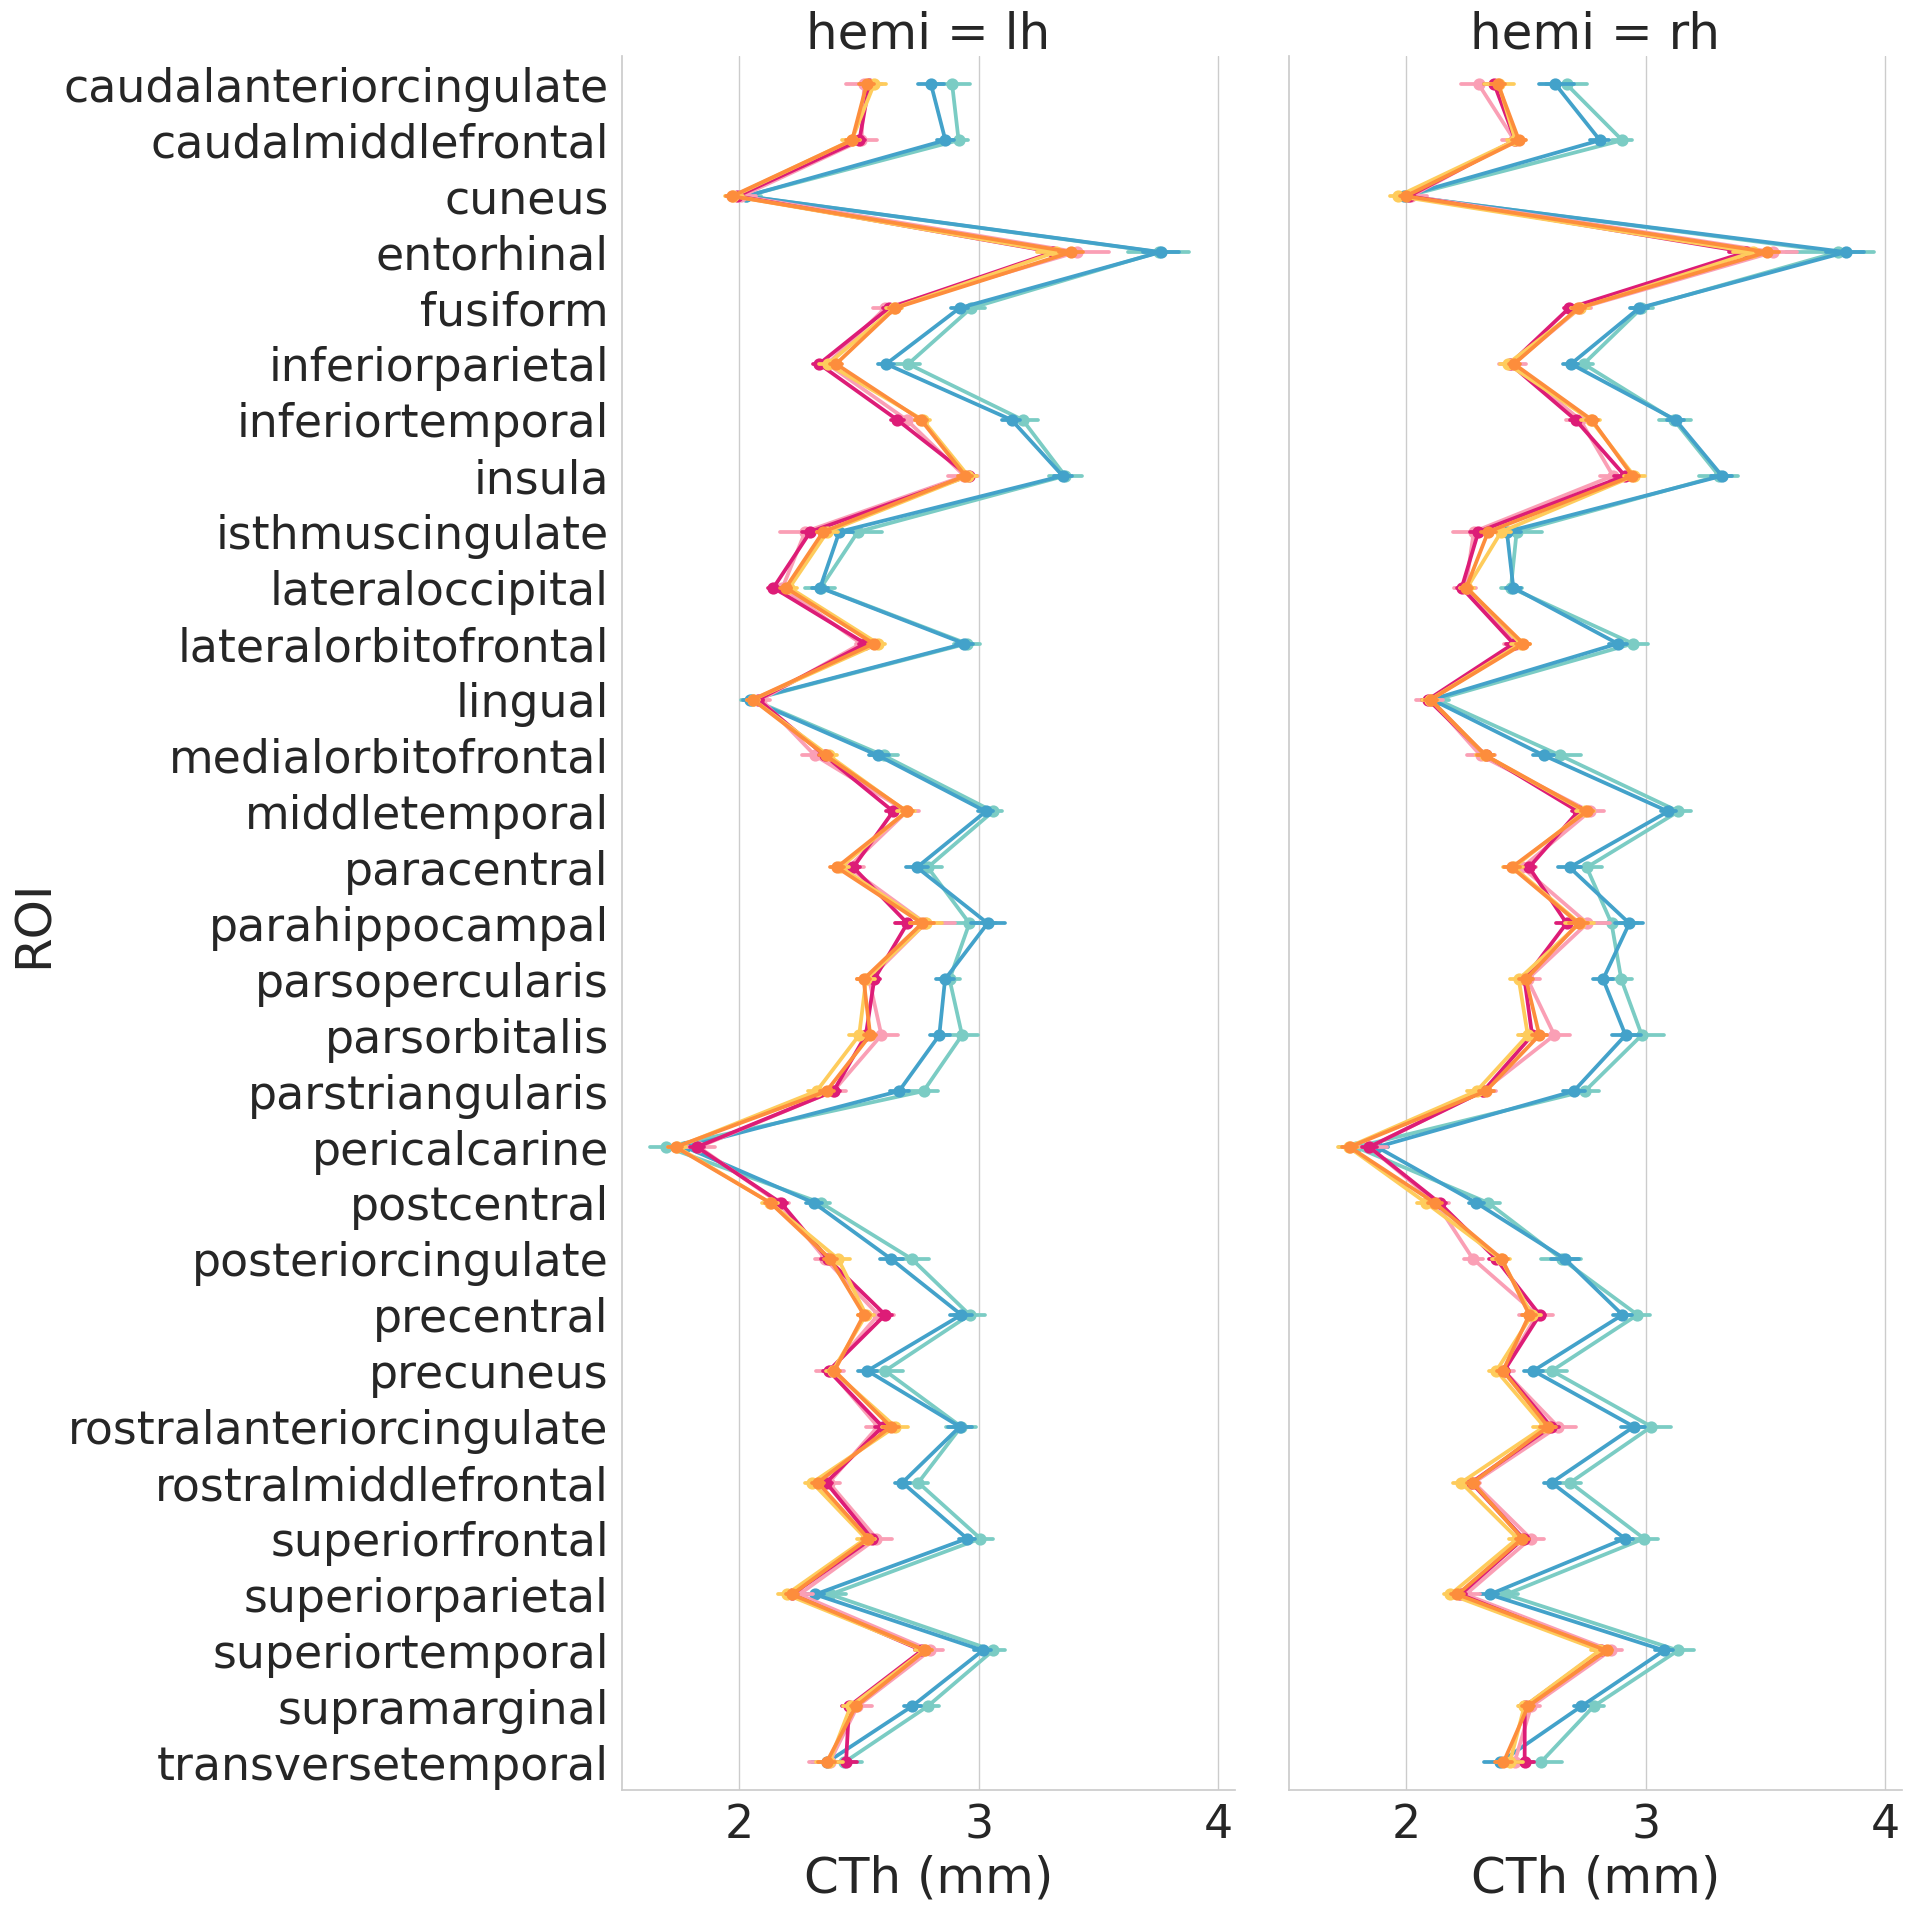

In [17]:
save_fig = False

CT_DKT_df = CT_DKT_df[CT_DKT_df["dataset"].isin(["PPMI", "QPN", "NIMHANS_SERB"])]
CT_DKT_df = CT_DKT_df[CT_DKT_df["group"].isin(["control", "PD"])]

# color_list = [my_colors.QPN_CONTROL.value, my_colors.QPN_PD.value, 
#               my_colors.PPMI_CONTROL.value, my_colors.PPMI_PRODROMAL.value, my_colors.PPMI_PD.value]

# palette = sns.color_palette(palette=color_list) 
# hue_order = ["NIMHANS_SERB-control","NIMHANS_SERB-PD","NIMHANS_METAL-PD", "QPN-control", "QPN-PD"] #"PPMI-prodromal", 
hue_order = ["NIMHANS_SERB-control", "NIMHANS_SERB-PD", "QPN-control", "QPN-PD",
              "PPMI-control",  "PPMI-PD"]

CT_DKT_df_melt = CT_DKT_df.melt(
    id_vars=demo_cols + ["ds_group"],
    var_name="ROI", 
    value_name="CTh (mm)")

plot_df = CT_DKT_df_melt.copy()
plot_df["ROI"] = plot_df["ROI"].astype(str)

sns.set(font_scale=3)
with sns.axes_style("whitegrid"):
    g = sns.catplot(y="ROI",x="CTh (mm)", hue="ds_group", col="hemi",kind="point",palette=palette, hue_order=hue_order, legend=False,
                    data=plot_df, aspect=0.5, height=20)
    # g.tick_params(axis='x', rotation=90, labelsize=14)

if save_fig:
    g.savefig(f"{figs_dir}/DKT.png")

### Aseg bilateral volume

In [14]:
# NIMHANS (SERB + METAL)
nimhans_serb_hemi_ASEG_df = pd.read_csv(f"{nimhans_serb_agg_data_dir}{bilateral_vol_csv}").drop(columns=["Unnamed: 0"])
nimhans_serb_hemi_ASEG_df["dataset"] = "NIMHANS_SERB"
n_nimhans_serb_participants = len(nimhans_serb_hemi_ASEG_df["participant_id"].unique())

nimhans_metal_hemi_ASEG_df = pd.read_csv(f"{nimhans_metal_agg_data_dir}{bilateral_vol_csv}").drop(columns=["Unnamed: 0"])
nimhans_metal_hemi_ASEG_df["dataset"] = "NIMHANS_METAL"
n_nimhans_metal_participants = len(nimhans_metal_hemi_ASEG_df["participant_id"].unique())

# QPN
qpn_hemi_ASEG_df = pd.read_csv(f"{qpn_agg_data_dir}{bilateral_vol_csv}").drop(columns=["Unnamed: 0"])
qpn_hemi_ASEG_df["dataset"] = "QPN"
n_qpn_participants = len(qpn_hemi_ASEG_df["participant_id"].unique())

# PPMI
ppmi_hemi_ASEG_df = pd.read_csv(f"{ppmi_agg_data_dir}{bilateral_vol_csv}").drop(columns=["Unnamed: 0"])
ppmi_hemi_ASEG_df["dataset"] = "PPMI"
n_ppmi_participants = len(ppmi_hemi_ASEG_df["participant_id"].unique())

print(f"n_nimhans_participants: {(n_nimhans_serb_participants,n_nimhans_metal_participants)}, n_qpn_participants:{n_qpn_participants}")

if match_age:
    print(f"Matching age < {age_thresh}")

    ppmi_hemi_ASEG_df = ppmi_hemi_ASEG_df[ppmi_hemi_ASEG_df["age"]<age_thresh]
    n_ppmi_participants = len(ppmi_hemi_ASEG_df["participant_id"].unique())

    qpn_hemi_ASEG_df = qpn_hemi_ASEG_df[qpn_hemi_ASEG_df["age"]<age_thresh]
    n_qpn_participants = len(qpn_hemi_ASEG_df["participant_id"].unique())
    print(f"n_nimhans_participants: {(n_nimhans_serb_participants,n_nimhans_metal_participants)}, n_qpn_participants:{n_qpn_participants}, n_ppmi_participants: {n_ppmi_participants}")


# Concat
hemi_ASEG_df = pd.concat([nimhans_serb_hemi_ASEG_df, nimhans_metal_hemi_ASEG_df, qpn_hemi_ASEG_df, ppmi_hemi_ASEG_df], axis=0)
hemi_ASEG_df["ds_group"] = hemi_ASEG_df["dataset"] + "-" + hemi_ASEG_df["group"]
print(f"hemi_ASEG_df shape: {hemi_ASEG_df.shape}")

# Add BIDS_ID for PPMI

## tmp
# hemi_ASEG_df = hemi_ASEG_df.drop(columns=["participant_id"])

hemi_ASEG_df

n_nimhans_participants: (86, 66), n_qpn_participants:201
Matching age < 63
n_nimhans_participants: (86, 66), n_qpn_participants:81, n_ppmi_participants: 195
hemi_ASEG_df shape: (856, 22)


,Cerebellum-White-Matter,Amygdala,Lateral-Ventricle,Cerebellum-Cortex,Putamen,Thalamus-Proper,vessel,choroid-plexus,Caudate,Hippocampus,...,Accumbens-area,Pallidum,participant_id,bids_id,age,sex,group,hemi,dataset,ds_group
0,14102.900391,1659.300049,9170.500000,49608.800781,4586.500000,6357.399902,125.800003,684.400024,3355.899902,3580.399902,...,394.600006,2000.800049,SERB088,sub-SERB088,54.0,M,PD,lh,NIMHANS_SERB,NIMHANS_SERB-PD
1,12641.299805,1223.000000,7667.399902,42569.199219,3512.899902,5716.799805,24.000000,623.900024,2633.600098,3400.500000,...,177.800003,1638.900024,SERB058,sub-SERB058,64.0,M,PD,lh,NIMHANS_SERB,NIMHANS_SERB-PD
2,20009.800781,1357.099976,16945.599609,50561.199219,4779.700195,6195.899902,29.299999,1066.400024,3021.699951,3541.500000,...,431.500000,2295.199951,SERB049,sub-SERB049,62.0,M,PD,lh,NIMHANS_SERB,NIMHANS_SERB-PD
3,10348.900391,1344.599976,10064.700195,41859.898438,2910.699951,5412.100098,13.900000,818.299988,1672.599976,3827.000000,...,349.500000,1645.500000,SERB084,sub-SERB084,NaN,NaN,PD,lh,NIMHANS_SERB,NIMHANS_SERB-PD
4,11251.599609,1442.900024,8531.599609,46157.500000,3410.100098,5824.899902,40.000000,592.799988,2352.199951,3377.800049,...,403.799988,1618.900024,SERB063,sub-SERB063,56.0,M,PD,lh,NIMHANS_SERB,NIMHANS_SERB-PD
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
888,12297.299805,1647.900024,6304.000000,47058.199219,5700.299805,7015.399902,26.900000,461.899994,3894.500000,4343.600098,...,402.500000,1856.699951,72138.0,NaN,55.0,F,prodromal,rh,PPMI,PPMI-prodromal
891,16517.199219,2246.399902,7955.000000,62509.800781,6420.899902,8903.599609,21.700001,784.000000,3768.100098,4984.899902,...,753.799988,2478.000000,3555.0,NaN,40.0,M,control,rh,PPMI,PPMI-control
893,17197.400391,1573.599976,7502.500000,52636.000000,4402.399902,5969.399902,19.600000,627.400024,3549.899902,4059.199951,...,397.299988,1580.900024,65002.0,NaN,62.0,F,prodromal,rh,PPMI,PPMI-prodromal
897,13363.700195,1552.500000,4275.500000,47396.300781,4096.299805,6303.600098,13.700000,287.500000,2847.800049,3580.699951,...,390.100006,1413.300049,3857.0,NaN,41.0,F,control,rh,PPMI,PPMI-control


/home/nikhil/projects/my_venvs/nipoppy/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/nikhil/projects/my_venvs/nipoppy/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/nikhil/projects/my_venvs/nipoppy/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/nikhil/projects/my_venvs/nipoppy/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be r

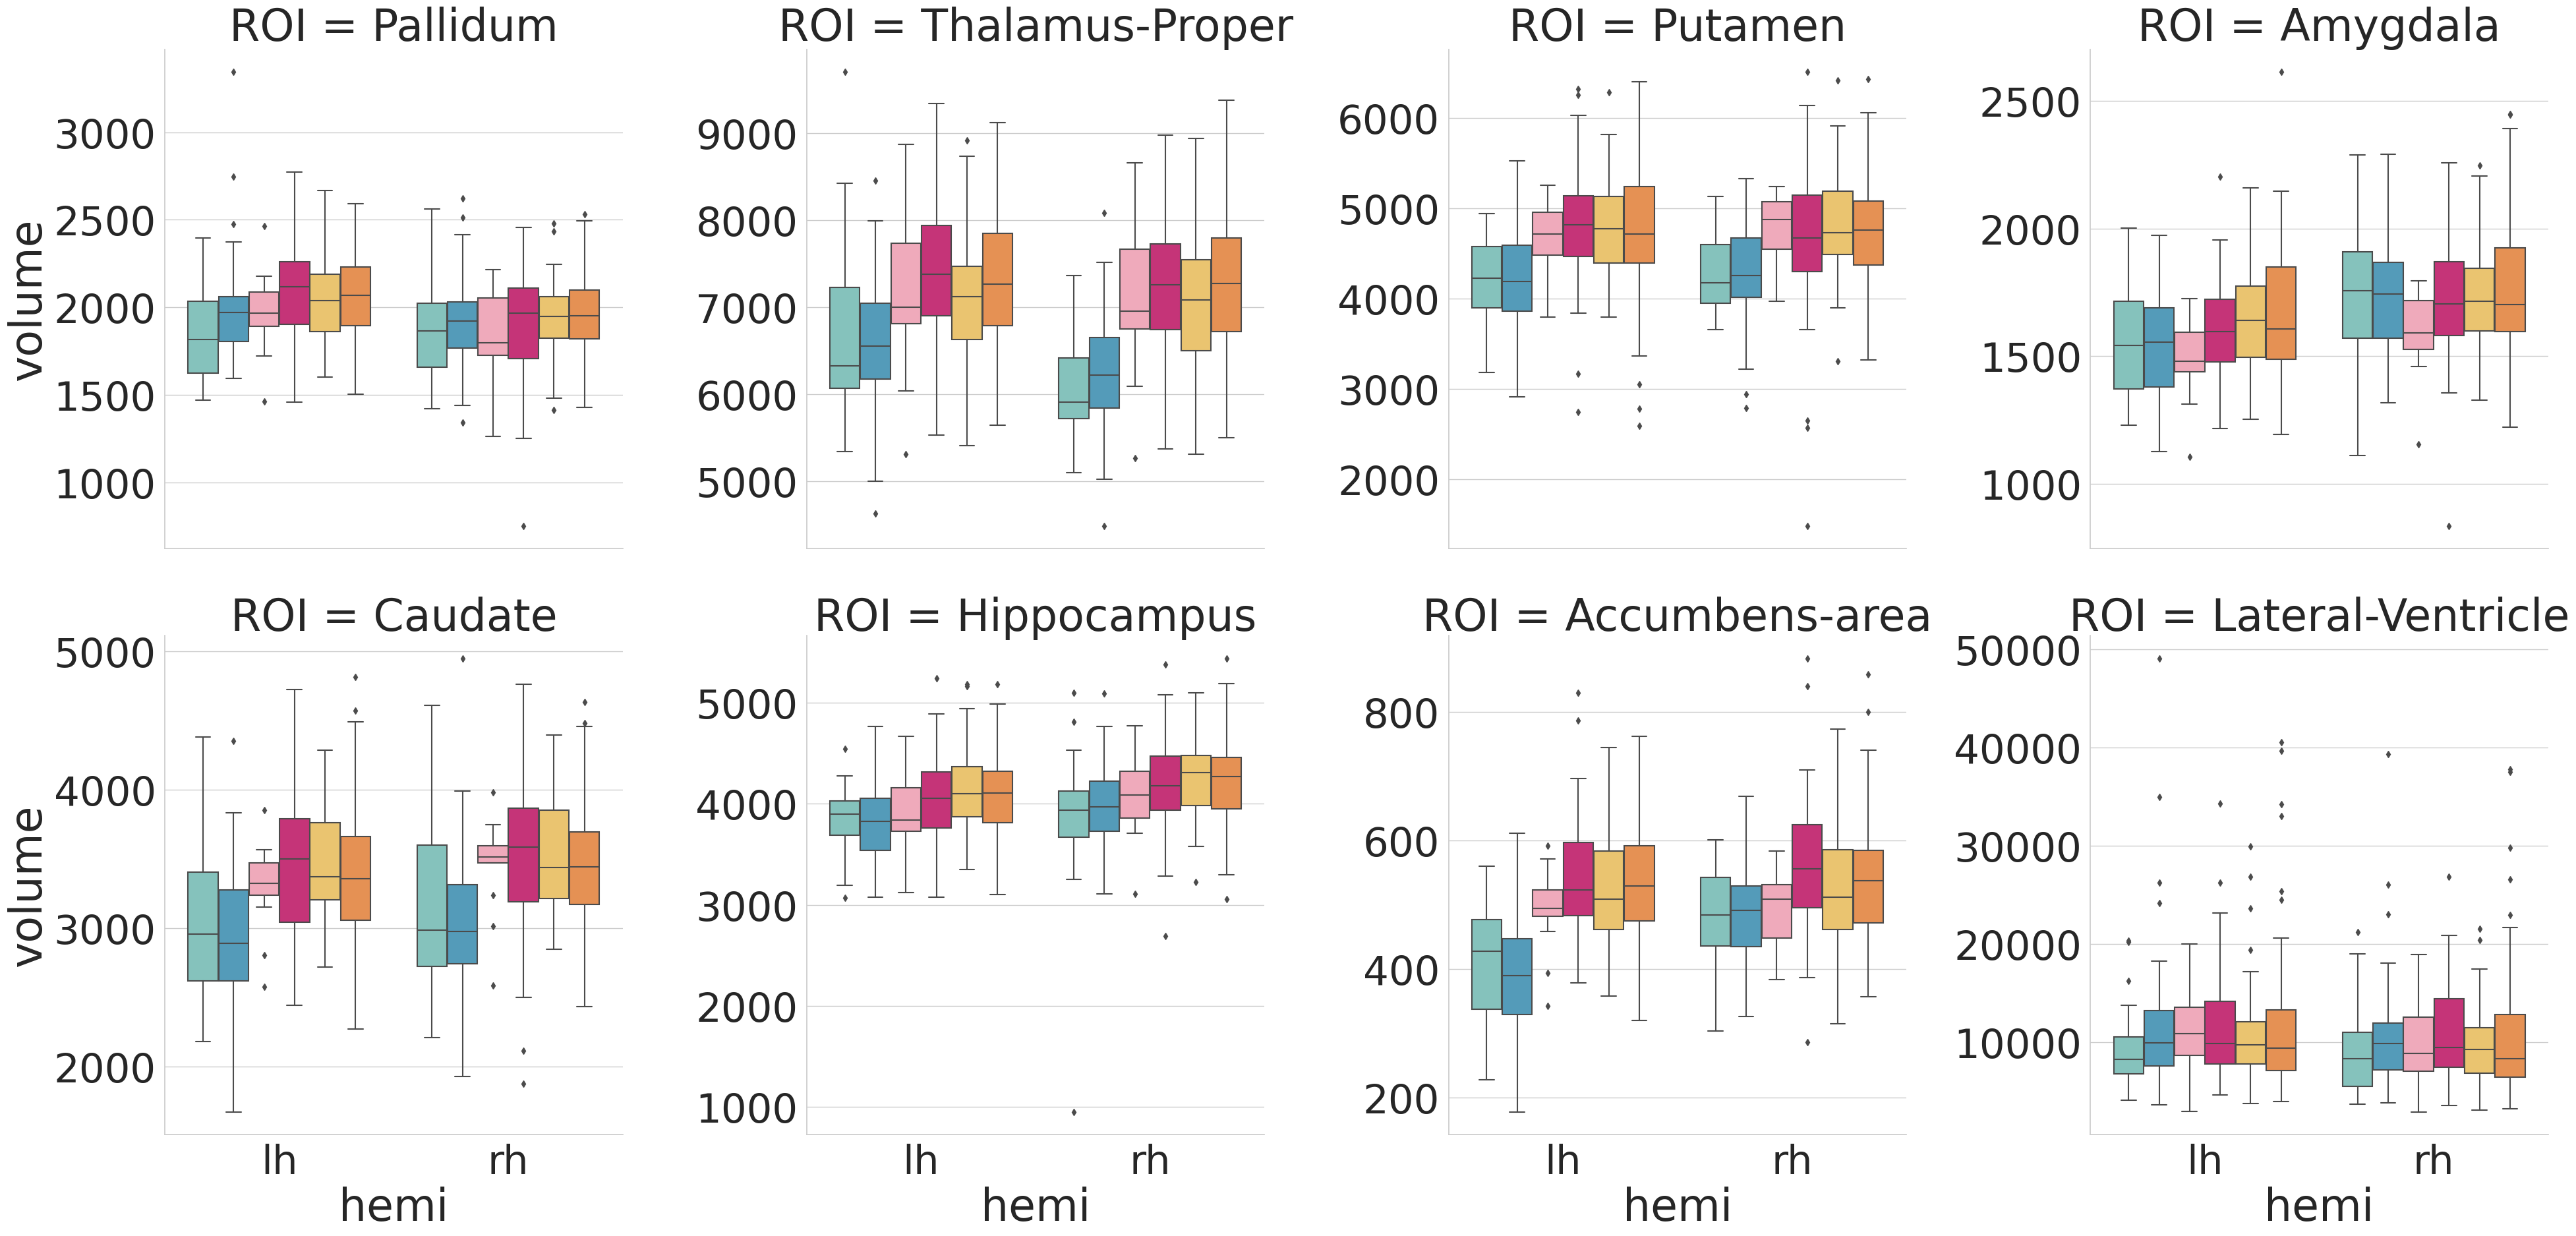

In [16]:
save_fig = False

hemi_ASEG_df = hemi_ASEG_df[hemi_ASEG_df["dataset"].isin(["PPMI", "QPN", "NIMHANS_SERB"])]
hemi_ASEG_df = hemi_ASEG_df[hemi_ASEG_df["group"].isin(["control", "PD"])]

vol_ASEG_df_melt = hemi_ASEG_df.melt(
    id_vars=demo_cols + ["ds_group"],
    var_name="ROI", 
    value_name="volume",
)

plot_df = vol_ASEG_df_melt.copy()
plot_df = plot_df.drop(columns=["participant_id"])

plot_df["ROI"] = plot_df["ROI"].astype(str)
hemi_roi_list = ['Pallidum', 'Thalamus-Proper', 'Putamen',  'Amygdala', 'Caudate', 'Hippocampus', 'Accumbens-area', 
                 'Lateral-Ventricle']
#'Cerebellum-Cortex','Cerebellum-White-Matter','VentralDC','Inf-Lat-Vent'

sns.set(font_scale=4)
with sns.axes_style("whitegrid"):
    g = sns.catplot(y="volume",x="hemi", hue="ds_group", col="ROI",kind="box", col_wrap=4, col_order=hemi_roi_list, hue_order=hue_order,
    palette=palette, data=plot_df, aspect=1, height=10, sharey=False, legend=False)
    # g.tick_params(axis='x', rotation=90, labelsize=14)

if save_fig:
    g.savefig(f"{figs_dir}/ASEG_hemi.png")

### Global volumes

In [18]:
# NIMHANS (SERB + METAL)
nimhans_serb_global_ASEG_df = pd.read_csv(f"{nimhans_serb_agg_data_dir}{global_vol_csv}").drop(columns=["Unnamed: 0"])
nimhans_serb_global_ASEG_df["dataset"] = "NIMHANS_SERB"
n_nimhans_serb_participants = len(nimhans_serb_global_ASEG_df["participant_id"].unique())

nimhans_metal_global_ASEG_df = pd.read_csv(f"{nimhans_metal_agg_data_dir}{global_vol_csv}").drop(columns=["Unnamed: 0"])
nimhans_metal_global_ASEG_df["dataset"] = "NIMHANS_METAL"
n_nimhans_metal_participants = len(nimhans_metal_global_ASEG_df["participant_id"].unique())

# QPN
qpn_global_ASEG_df = pd.read_csv(f"{qpn_agg_data_dir}{global_vol_csv}").drop(columns=["Unnamed: 0"])
qpn_global_ASEG_df["dataset"] = "QPN"
n_qpn_participants = len(qpn_global_ASEG_df["participant_id"].unique())

# PPMI
ppmi_global_ASEG_df = pd.read_csv(f"{ppmi_agg_data_dir}{global_vol_csv}").drop(columns=["Unnamed: 0"])
ppmi_global_ASEG_df["dataset"] = "PPMI"
n_ppmi_participants = len(ppmi_global_ASEG_df["participant_id"].unique())

print(f"n_nimhans_participants: {(n_nimhans_serb_participants, n_nimhans_metal_participants)}, n_qpn_participants:{n_qpn_participants}")

if match_age:
    print(f"Matching age < {age_thresh}")

    ppmi_global_ASEG_df = ppmi_global_ASEG_df[ppmi_global_ASEG_df["age"]<age_thresh]
    n_ppmi_participants = len(ppmi_global_ASEG_df["participant_id"].unique())

    qpn_global_ASEG_df = qpn_global_ASEG_df[qpn_global_ASEG_df["age"]<age_thresh]
    n_qpn_participants = len(qpn_global_ASEG_df["participant_id"].unique())
    print(f"n_nimhans_participants: {(n_nimhans_serb_participants, n_nimhans_metal_participants)}, n_qpn_participant:{n_qpn_participants}, n_ppmi_participants: {n_ppmi_participants}")

# Concat
global_vol_ASEG_df = pd.concat([nimhans_serb_global_ASEG_df, nimhans_metal_global_ASEG_df, qpn_global_ASEG_df, ppmi_global_ASEG_df], axis=0)
global_vol_ASEG_df["ds_group"] = global_vol_ASEG_df["dataset"] + "-" + global_vol_ASEG_df["group"]
print(f"global_vol_ASEG_df shape: {global_vol_ASEG_df.shape}")

## tmp
# qpn_global_ASEG_df = qpn_global_ASEG_df.drop(columns=["participant_id"])

qpn_global_ASEG_df

n_nimhans_participants: (86, 66), n_qpn_participants:201
Matching age < 63
n_nimhans_participants: (86, 66), n_qpn_participant:81, n_ppmi_participants: 195
global_vol_ASEG_df shape: (428, 24)


,4th-Ventricle,BrainSegNotVentSurf,SubCortGray,5th-Ventricle,Brain-Stem,Optic-Chiasm,WM-hypointensities,EstimatedTotalIntraCranial,TotalGray,SupraTentorial,...,BrainSegNotVent,BrainSeg,3rd-Ventricle,participant_id,bids_id,age,sex,group,hemi,dataset
1,2606.399902,1.423165e+06,70481.0,0.0,26626.500000,212.199997,1731.000000,1.932300e+06,779374.258473,1.280777e+06,...,1423757.0,1457215.0,1887.400024,PD00215,sub-PD00215,48.5,M,PD,global,QPN
3,1684.199951,1.076999e+06,56202.0,0.0,21090.699219,121.800003,3868.699951,1.492908e+06,584506.867513,1.002630e+06,...,1077374.0,1114040.0,1175.000000,PD01398,sub-PD01398,61.9,F,PD,global,QPN
4,1408.300049,8.435806e+05,44332.0,0.0,15741.799805,114.099998,1220.400024,1.146054e+06,506704.879814,7.560226e+05,...,843682.0,861734.0,1069.199951,PD00849,sub-PD00849,62.2,F,PD,global,QPN
5,1837.300049,1.016271e+06,53094.0,0.0,20252.800781,133.500000,713.799988,1.434878e+06,582104.554283,9.016352e+05,...,1016472.0,1040177.0,1431.000000,PD01746,sub-PD01746,55.4,F,control,global,QPN
9,1678.199951,1.187711e+06,60897.0,0.0,21935.000000,128.699997,787.700012,1.623276e+06,669289.174266,1.074158e+06,...,1187530.0,1208224.0,1142.800049,PD01710,sub-PD01710,50.6,M,PD,global,QPN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
189,1367.699951,1.168711e+06,60055.0,0.0,24675.000000,120.099998,1515.699951,1.625055e+06,640856.310684,1.049299e+06,...,1168687.0,1198648.0,1323.400024,PD01187,sub-PD01187,50.4,M,PD,global,QPN
191,1460.099976,1.234339e+06,61404.0,0.0,26240.800781,76.300003,1507.300049,1.686554e+06,681059.785072,1.108911e+06,...,1234532.0,1255068.0,926.900024,PD00955,sub-PD00955,59.9,M,PD,global,QPN
192,2445.300049,1.102947e+06,57561.0,0.0,24184.699219,172.600006,1844.400024,1.567157e+06,624004.719477,9.730359e+05,...,1103613.0,1126870.0,1785.599976,PD01284,sub-PD01284,61.8,M,PD,global,QPN
194,2014.900024,1.023220e+06,53106.0,0.0,19477.699219,128.399994,2185.199951,1.526238e+06,598734.052470,9.424512e+05,...,1023611.0,1064401.0,1833.900024,PD01217,sub-PD01217,60.8,M,PD,global,QPN


/home/nikhil/projects/my_venvs/nipoppy/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/nikhil/projects/my_venvs/nipoppy/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/nikhil/projects/my_venvs/nipoppy/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/nikhil/projects/my_venvs/nipoppy/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be r

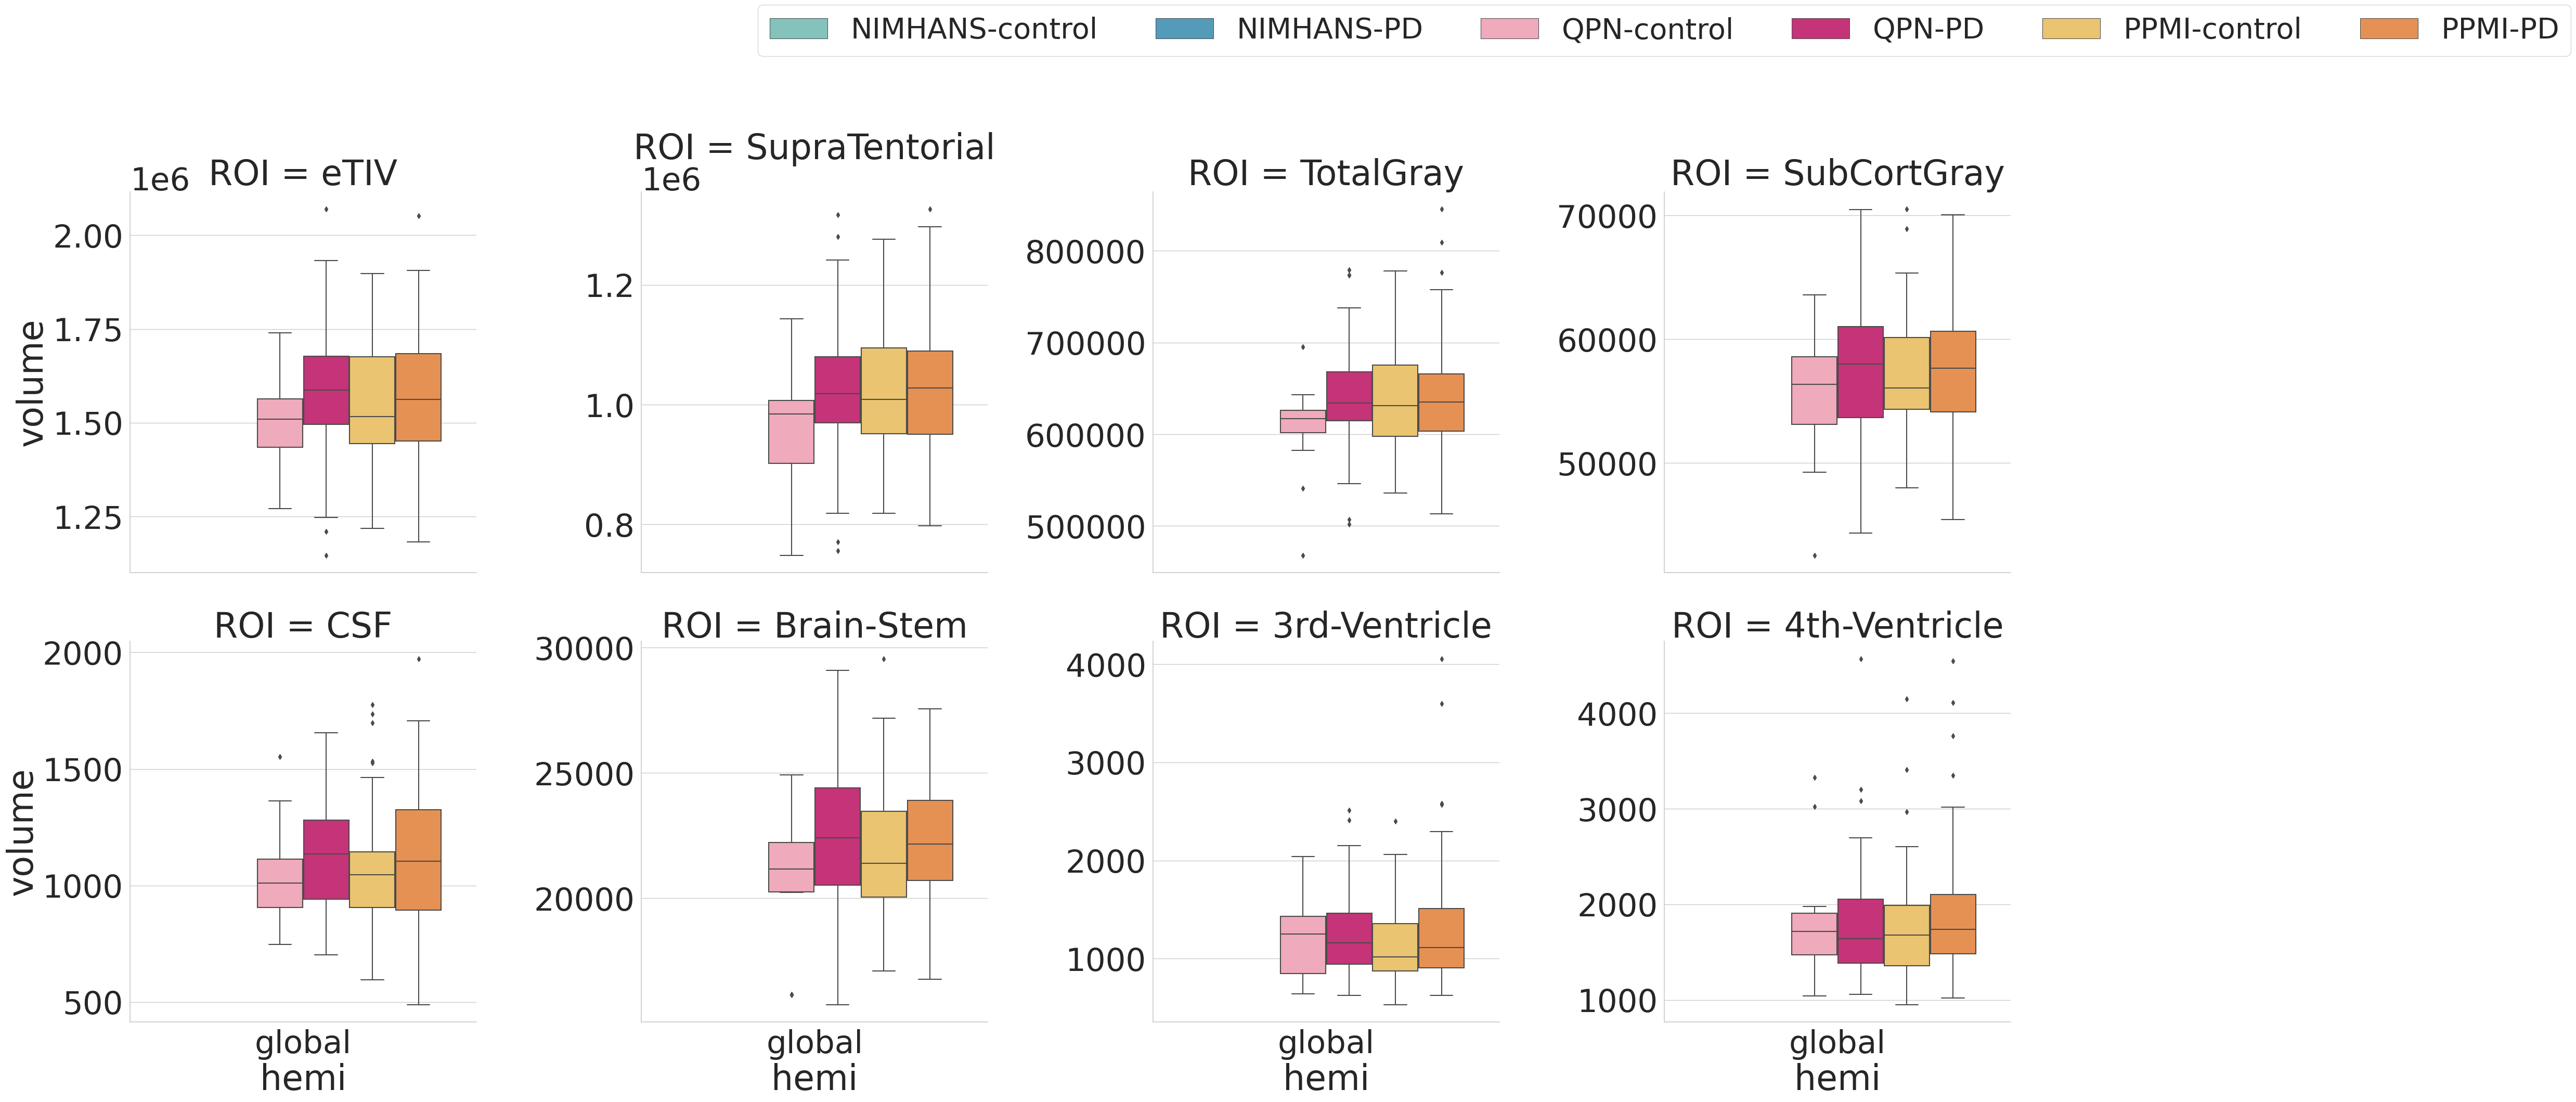

In [21]:
save_fig = False

global_vol_ASEG_df = global_vol_ASEG_df[global_vol_ASEG_df["dataset"].isin(["PPMI", "QPN"])]
global_vol_ASEG_df = global_vol_ASEG_df[global_vol_ASEG_df["group"].isin(["control", "PD"])]

global_vol_ASEG_df = global_vol_ASEG_df.rename(columns={"EstimatedTotalIntraCranial":"eTIV"})

global_vol_ASEG_df_melt = global_vol_ASEG_df.melt(
    id_vars=demo_cols + ["ds_group"],
    var_name="ROI", 
    value_name="volume",
)

plot_df = global_vol_ASEG_df_melt.copy()

global_roi_list = ["eTIV", "SupraTentorial", "TotalGray", "SubCortGray", 
                    "CSF","Brain-Stem","3rd-Ventricle","4th-Ventricle"]
plot_df = plot_df[plot_df["ROI"].isin(global_roi_list)]

plot_df["ds_group"] = plot_df["ds_group"].replace({"NIMHANS_SERB-control":"nimhans-control", 
                                                    "NIMHANS_SERB-PD":"nimhans-PD", 
                                                    })
hue_order = ["NIMHANS-control", "NIMHANS-PD", "QPN-control", "QPN-PD", "PPMI-control",  "PPMI-PD"]
sns.set(font_scale=4)
with sns.axes_style("whitegrid"):
    g = sns.catplot(y="volume",x="hemi", hue="ds_group", col="ROI", kind="box", col_wrap=4, col_order=global_roi_list, hue_order=hue_order,
    palette=palette, data=plot_df, aspect=1, height=10, sharey=False, legend=False)
    
    plt.legend(bbox_to_anchor =(0,2.5), loc='lower center',ncol=7, fontsize=40)

if save_fig:
    g.savefig(f"{figs_dir}/ASEG_global.png")

### Demographics

In [15]:
demo_df = global_vol_ASEG_df[demo_cols].copy()
demo_df.groupby(["dataset","group"]).count()

participant_id  bids_id  age  sex  hemi
dataset       group                                           
NIMHANS_METAL PD                   66       66   59   59    66
NIMHANS_SERB  PD                   64       64   54   55    64
              control              22       22   15   15    22
PPMI          PD                  105        0  105  105   105
              control              42        0   42   42    42
QPN           PD                   68       68   68   68    68
              control              13       13   13   13    13

In [16]:
demo_df.groupby(["dataset","group"])["age"].describe()

count       mean        std   min    25%   50%    75%  \
dataset       group                                                            
NIMHANS_METAL PD        59.0  53.644068  10.133187  24.0  46.00  55.0  61.00   
NIMHANS_SERB  PD        54.0  55.388889   7.199100  36.0  50.25  56.0  61.00   
              control   15.0  52.000000   6.011893  41.0  49.00  53.0  56.50   
PPMI          PD       105.0  54.247619   5.705566  38.0  50.00  55.0  59.00   
              control   42.0  51.642857   7.938242  31.0  46.25  53.5  57.75   
QPN           PD        68.0  55.961765   5.299423  40.9  53.20  57.1  60.05   
              control   13.0  52.515385   7.785547  37.7  49.80  55.4  57.60   

                        max  
dataset       group          
NIMHANS_METAL PD       72.0  
NIMHANS_SERB  PD       67.0  
              control  60.0  
PPMI          PD       62.0  
              control  62.0  
QPN           PD       62.9  
              control  62.6

### OLS

In [17]:
import statsmodels.api as sm
import statsmodels.formula.api as smf

In [18]:
stat_df = global_vol_ASEG_df.copy()
dataset_list = ["NIMHANS_SERB","QPN"]
hemi = "global"
stat_df = stat_df[(stat_df["dataset"].isin(dataset_list)) & (stat_df["hemi"]==hemi)]

brain_var = "eTIV"
demo_vars = ["participant_id","age","sex","group","hemi","dataset"]

input_var = demo_vars + [brain_var]

stat_df = stat_df[input_var]
stat_df.head()

,participant_id,age,sex,group,hemi,dataset,eTIV
0,SERB088,54.0,M,PD,global,NIMHANS_SERB,1.426910e+06
1,SERB058,64.0,M,PD,global,NIMHANS_SERB,1.296458e+06
2,SERB049,62.0,M,PD,global,NIMHANS_SERB,1.566405e+06
3,SERB084,NaN,NaN,PD,global,NIMHANS_SERB,1.213594e+06
4,SERB063,56.0,M,PD,global,NIMHANS_SERB,1.264406e+06


In [19]:
def get_stats(stat_df, ind_var, dep_var, cat_vars, global_correction=False):
    cvar_str = ""
    for cvar in cat_vars:
        cvar_str = "".join([f"{cvar_str} + C({cvar})"])    

    if global_correction:
        formula = f"{ind_var} ~ {dep_var}{cvar_str} + {global_correction}"
    else:
        formula = f"{ind_var} ~ {dep_var}{cvar_str}"
        
    res = smf.ols(formula=formula, data=stat_df).fit()
    
    tval_df = pd.DataFrame(columns=["tvalues"], data=res.tvalues)
    pval_df = pd.DataFrame(columns=["pvalues"], data=res.pvalues)
    res_df = pd.concat([tval_df, pval_df], axis=1)
    res_df = res_df.reset_index().rename(columns={"index":"var"})

    return res_df, res, formula

### Replication analysis
- Group differences within each dataset

In [20]:
dep_var = "age"
cat_vars = ["sex", "group"]
dataset_list = ["NIMHANS_SERB","QPN","PPMI"]

pval_thresh = 0.05

### Global volumes

In [21]:
brain_roi_list = ["eTIV", "SupraTentorial", "TotalGray", "SubCortGray", "CSF"]
hemi = "global"
res_df = pd.DataFrame()
for ds in dataset_list:
    for ind_var in brain_roi_list:
        # print(f"ds:{ds}, ind_var:{ind_var}")
        stat_df = global_vol_ASEG_df.copy()
        stat_df = stat_df[(stat_df["dataset"]==ds) & (stat_df["hemi"]==hemi)]
        _df, res, formula = get_stats(stat_df, ind_var, dep_var, cat_vars)
        _df["ROI"] = ind_var
        _df["hemi"] = hemi
        _df["dataset"] = ds
        res_df = pd.concat([res_df, _df], axis=0)


res_df[(res_df["var"]=="C(group)[T.control]") & (res_df["pvalues"] < pval_thresh)]

,var,tvalues,pvalues,ROI,hemi,dataset
2,C(group)[T.control],-2.098707,0.039121,TotalGray,global,QPN


### Subcortical volumes

In [22]:
brain_roi_list = ['Pallidum', 'ThalamusProper', 'Putamen',  'Amygdala', 'Caudate', 'Hippocampus', 'AccumbensArea']
hemi_list = ["lh", "rh"]
global_correction = "eTIV"
# rename columns with "-" to remove error in statsmodels
hemi_ASEG_df = hemi_ASEG_df.rename(columns={"Thalamus-Proper":"ThalamusProper", 'Accumbens-area':'AccumbensArea'})

res_df = pd.DataFrame()
for ds in dataset_list:
    for ind_var in brain_roi_list:
        for hemi in hemi_list:
            # print(f"ds:{ds}, ind_var:{ind_var}")
            stat_df = hemi_ASEG_df.copy()
            stat_df = stat_df[(stat_df["dataset"]==ds) & (stat_df["hemi"]==hemi)]

            if global_correction:
                stat_df = pd.merge(stat_df, global_vol_ASEG_df[["participant_id","eTIV"]], on="participant_id", how="left")
                _df, _, formula = get_stats(stat_df, ind_var, dep_var, cat_vars, global_correction)
            else:
                _df, _, formula = get_stats(stat_df, ind_var, dep_var, cat_vars)

            _df["ROI"] = ind_var
            _df["hemi"] = hemi
            _df["dataset"] = ds
            res_df = pd.concat([res_df, _df], axis=0)


res_df[(res_df["var"]=="C(group)[T.control]") & (res_df["pvalues"] < pval_thresh)]

,var,tvalues,pvalues,ROI,hemi,dataset
2,C(group)[T.control],-2.180160,0.032341,AccumbensArea,rh,QPN
2,C(group)[T.control],-2.175419,0.031254,ThalamusProper,lh,PPMI
2,C(group)[T.control],-1.981722,0.049441,ThalamusProper,rh,PPMI


### CTh

In [23]:
brain_roi_list = CT_DKT_df[CT_DKT_df.columns[~CT_DKT_df.columns.isin(demo_cols + ["ds_group"])]].columns
print(f"n_brain_rois: {len(brain_roi_list)}")
hemi_list = ["lh", "rh"]

res_df = pd.DataFrame()
for ds in dataset_list:
    for ind_var in brain_roi_list:
        for hemi in hemi_list:
            # print(f"ds:{ds}, ind_var:{ind_var}")
            stat_df = CT_DKT_df.copy()
            stat_df = stat_df[(stat_df["dataset"]==ds) & (stat_df["hemi"]==hemi)]
            _df, _, formula = get_stats(stat_df, ind_var, dep_var, cat_vars)
            _df["ROI"] = ind_var
            _df["hemi"] = hemi
            _df["dataset"] = ds
            res_df = pd.concat([res_df, _df], axis=0)


res_df[(res_df["var"]=="C(group)[T.control]") & (res_df["pvalues"] < pval_thresh)]

n_brain_rois: 31


,var,tvalues,pvalues,ROI,hemi,dataset
2,C(group)[T.control],-2.094447,0.040123,posteriorcingulate,rh,NIMHANS_SERB
2,C(group)[T.control],-3.161196,0.002247,posteriorcingulate,rh,QPN


### Cross-cohort comparisons

In [ ]:
brain_roi_list = ["eTIV", "SupraTentorial", "TotalGray", "SubCortGray", "CSF"]
dep_var = "age"
cat_vars = ["sex", "ds_group"]
pval_thresh = 0.05

group_list = ["control","PD"]
hemi = "global"
res_df = pd.DataFrame()
for grp in group_list:
    for ind_var in brain_roi_list:
        # print(f"ds:{ds}, ind_var:{ind_var}")
        stat_df = global_vol_ASEG_df.copy()
        stat_df = stat_df[(stat_df["group"]==grp) & (stat_df["hemi"]==hemi)]
        _df = get_stats(stat_df, ind_var, dep_var, cat_vars)
        _df["ROI"] = ind_var
        _df["hemi"] = hemi
        _df["group"] = grp
        res_df = pd.concat([res_df, _df], axis=0)


res_df[(~res_df["var"].isin(["Intercept","C(sex)[T.M]","age"])) & (res_df["pvalues"] < pval_thresh)]